### Random walks and image segmentation

Via simple examples we visualise the use of random walks for image segmentation<!-- .slide: data-fullscreen -->

At the beginning, images are represented as a grid networks of pixels, each one having a color value. 

By making the walkers avoid neighbour pixels that are too `different` from the one they're on, we are forcing them to stay in the same region of the image, thus segmenting it.


In [424]:
import matplotlib.pyplot as plt

import numpy as np

import random as rand

Let's look at the benckmark image seen in class, a B29 Stratofortress flying over a cloudy sky: can we automatically detect it?

That is image 3096 the [Berkley Segmentation Dataset and Benchmark](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/)

The image below (a JPG version of the original PNG image) is $481\times 321=154,401$ pixels in size.


 A simplified dataset it the [BSD68 benckmark dataset](https://github.com/clausmichele/CBSD68-dataset/tree/master) which is a collection of images with a ground truth-segmentation mask that is used to benchmark *denoising*

![](https://raw.githubusercontent.com/clausmichele/CBSD68-dataset/master/CBSD68/groundtruth/airplane.png)

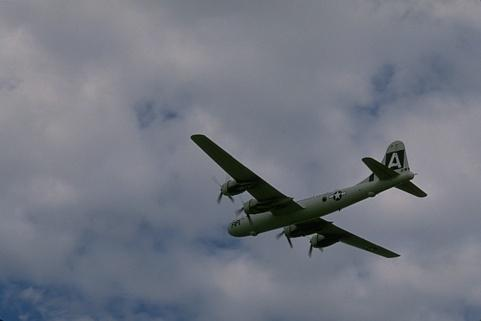

Find the original image and some example segmentations at [eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/3096.html](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/3096.html)

The random walks are started from a set of `seed` pixels, which are the ones we want to keep in the same segment.

In [425]:
import numpy as np

import scipy as sp

import matplotlib.pyplot as plt

from PIL import Image

In [426]:
IMGFILE = './imgs/0000.png'

In [427]:
bitmap = np.array((481, 321, 3))

In [428]:
bitmap = Image.open(IMGFILE)


In [429]:
# is it the right image?
# bitmap

In [430]:
matrix = np.array(bitmap)

print(matrix.shape)

print(matrix[0, 0, :])

(321, 481, 3)
[135 138 143]


In [431]:
# the key dimensions
M = matrix.shape[0]
N = matrix.shape[1]

#### Norms

Compute the difference, in color, between adjacent pixels.

Such difference is the norm of the difference vector in the 3-dimensional *space of color,* where values are in the 0..255 interval.

This is the formula from the slides:

$|p_{ij}|_3 = \frac{1}{\sqrt{3}} \sqrt{\frac{p^{red}_{ij}+p^{green}_{ij}+p^{blue}_{ij}}{255}}$


In [432]:
def three_norm(pixel)->float:
    red = pixel[0]
    green = pixel[1]
    blue = pixel[2]

    norm = np.sqrt((red**2 + green**2 + blue**2)/255)
    return norm/np.sqrt(3)

Compute the raw differences, then normalise them as they will be the probability distribution for the fairweather fan walking around.

for each pixel, identified by the (r,c) coordinates, the third dimension will be the distance to the right, above, left, and below pixels, respectively.

In [433]:
distances = np.zeros((M, N, 4))

for r in range(M):
    for c in range(N):
        pixel = matrix[r, c, :]
        
        spot_value = three_norm(pixel)

        # distance to the pixel to the right
        if c < N - 2:
            distances[r][c][0] = np.abs(spot_value - three_norm(matrix[r, c+1, :]))

        # distance to the pixel above
        if r > 0:
            distances[r][c][1] = np.abs(spot_value - three_norm(matrix[r-1, c, :]))
            
        # distance to the pixel to the left
        if c > 0:
            distances[r][c][2] = np.abs(spot_value - three_norm(matrix[r, c-1, :]))
        
        # it can move to the left
        if r < M-2:
            distances[r][c][3] = np.abs(spot_value - three_norm(matrix[r+1, c, :]))
        

C:\Users\ale\AppData\Local\Temp\ipykernel_25272\3895496605.py:6: RuntimeWarning: overflow encountered in scalar add
  norm = np.sqrt((red**2 + green**2 + blue**2)/255)


Make the third dimension into a prob. distribution.

In [434]:
for r in range(M):
    for c in range(N):
        sum = np.sum(distances[r, c, :])

        distances[r, c, :] = np.where(sum != 0, distances[r, c, :] / sum, 0)


C:\Users\ale\AppData\Local\Temp\ipykernel_25272\2008192714.py:5: RuntimeWarning: invalid value encountered in divide
  distances[r, c, :] = np.where(sum != 0, distances[r, c, :] / sum, 0)


#### Random walks

we are going to use the `random_walker` function from `skimage.segmentation`. 


This function takes an image and a set of seed pixels, and returns a segmentation of the image based on the random walk algorithm.

In [435]:
WALKERS = 100

# Lenght of the walk
STEPS = 10000

Boundaries is the matrix/image recording the walks

In [436]:
boundaries = np.zeros([M, N, 1])

print(boundaries.shape)

(321, 481, 1)


In [437]:
# seed it to the room number you are in when running it
seed = np.random.RandomState(407)

rng = np.random.default_rng()

Now we run a number (`WALKERS`) of separated random walkers, each covering a number (`STEPS`) of steps<!-- .slide: data-fullscreen -->

This corresponds, in the *fair-weather fan* scenario, to the fairweather fans attending `STEPS` games.

In [438]:
walks = np.zeros((WALKERS, STEPS+1, 2), dtype=int)

In [439]:
for w in range(WALKERS):

    # land the walker at a random pixel
    x = rand.randint(0, M)
    y = rand.randint(0, N)
    
    walks[w][0] = [x,y]
    
    for i in range(1, STEPS):

        x, y = walks[w][i-1]

        neighbors = []

        # it can move to the right
        if x < M - 2:
            neighbors.append((x+1, y))
        else:
            # this is padded in order to avoid index errors
            neighbors.append((x, y))

        # it can move up
        if y > 0:
            neighbors.append((x, y-1))
        else:
            # this is padded in order to avoid index errors
            neighbors.append((x, y))
            
        # it can move to the left
        if x > 0:
            neighbors.append((x-1, y))            
        else:
            # this is padded in order to avoid index errors
            neighbors.append((x, y))
            
        # it can move down
        if y < N - 2:
            neighbors.append((x, y+1))
        else:
            # this is padded in order to avoid index errors
            neighbors.append((x, y))        

        next_step = rng.choice(neighbors, 1, p=distances[x, y, :])

        walks[w][i][:] = (next_step[0][0], next_step[0][1])
        print(walks[w][i][:])
        
        # light up the pixel as it passess through
        # TODO: log the increment to avoid overflooding over 255
        boundaries[x, y, 0] += 1
        

[ 31 448]
[ 31 449]
[ 31 450]
[ 30 450]
[ 29 450]
[ 28 450]
[ 28 449]
[ 29 449]
[ 30 449]
[ 30 448]
[ 30 447]
[ 30 446]
[ 30 445]
[ 30 444]
[ 29 444]
[ 28 444]
[ 27 444]
[ 26 444]
[ 25 444]
[ 25 443]
[ 24 443]
[ 24 442]
[ 25 442]
[ 26 442]
[ 27 442]
[ 27 443]
[ 28 443]
[ 29 443]
[ 30 443]
[ 31 443]
[ 32 443]
[ 32 444]
[ 32 445]
[ 32 444]
[ 32 445]
[ 33 445]
[ 33 444]
[ 33 445]
[ 33 444]
[ 33 443]
[ 33 442]
[ 32 442]
[ 32 441]
[ 33 441]
[ 34 441]
[ 35 441]
[ 35 442]
[ 35 443]
[ 35 444]
[ 36 444]
[ 36 445]
[ 37 445]
[ 36 445]
[ 37 445]
[ 37 446]
[ 37 445]
[ 37 446]
[ 37 447]
[ 36 447]
[ 37 447]
[ 36 447]
[ 35 447]
[ 36 447]
[ 36 448]
[ 36 447]
[ 36 448]
[ 36 447]
[ 35 447]
[ 36 447]
[ 36 448]
[ 36 447]
[ 37 447]
[ 37 446]
[ 38 446]
[ 38 447]
[ 39 447]
[ 39 446]
[ 39 445]
[ 38 445]
[ 38 444]
[ 38 443]
[ 37 443]
[ 37 442]
[ 36 442]
[ 36 443]
[ 36 442]
[ 36 443]
[ 36 444]
[ 36 445]
[ 37 445]
[ 37 446]
[ 38 446]
[ 37 446]
[ 37 445]
[ 37 446]
[ 38 446]
[ 38 445]
[ 39 445]
[ 39 444]
[ 39 445]


ValueError: Probabilities do not sum to 1. See Notes section of docstring for more information.

Let's visualise the result.

In [ ]:
plt.matshow(boundaries[ : , : , 0], cmap='gray')
plt.axis('off')
plt.show()